

# Programmatic Molecular Docking 

This <font color='orange'>**WEB**</font>**DOCK** notebook is designed for conducting basic molecular docking in the brwoser without any sign-up/in requirement, with **Binder**. **Pdbfixer** used to prepare the protein, **Open Babel** used to prepare the ligand, **Simna 1.2.5** for docking, and performing binding interaction analysis with **Prolif 1.1.0**.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/quantaosun/webdock/HEAD?labpath=webdock_v.0.0.2.ipynb)
[![version](https://img.shields.io/badge/version-0.0.0-blue)](https://github.com/quantaosun/webdock)

# User Inputs
- PDB_ID is a four-letter code from PDB bank website, for example 3HTB

- Ligand below means the native ligand of co-crystal structure of PDB bank, it can be found on the PDB website, it should always be a three-letter code, for exampe JZ4
- smiles is the small molecule you want to dock, you can obtain this from chemdraw, from Edit > Copy as smiles

- The first three cells are the only thing you should modify. From top left, click Run > Run All Cells, the docking will start automaticlly



In [1]:
PDB_ID = "6I5I"

In [2]:
Ligand = "H3E"

In [3]:
smiles = "FC1=NC=C(N(CC2=CC=CC=C2)C=C3)C3=C1"

# Docking in progress, usually around 2-6 min. 
-Progress avaliable on top right corner if you hover your mouse there

In [4]:
path = "." #@param {type:"string"}
%cd '{path}'
pdb = PDB_ID + ".pdb"

/home/jovyan


In [5]:
! wget https://files.rcsb.org/download/$pdb

--2023-10-30 12:03:14--  https://files.rcsb.org/download/6I5I.pdb
Resolving files.rcsb.org (files.rcsb.org)... 128.6.159.100
Connecting to files.rcsb.org (files.rcsb.org)|128.6.159.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘6I5I.pdb’

6I5I.pdb                [  <=>               ] 520.01K  1.36MB/s    in 0.4s    

2023-10-30 12:03:15 (1.36 MB/s) - ‘6I5I.pdb’ saved [532494]



In [6]:
!wget --no-check-certificate https://sourceforge.net/projects/smina/files/smina.static/download -O smina.static 2>&1 1>/dev/null
!chmod u+x smina.static

--2023-10-30 12:03:16--  https://sourceforge.net/projects/smina/files/smina.static/download
Resolving sourceforge.net (sourceforge.net)... 172.64.150.145, 104.18.37.111, 2606:4700:4400::ac40:9691, ...
Connecting to sourceforge.net (sourceforge.net)|172.64.150.145|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloads.sourceforge.net/project/smina/smina.static?ts=gAAAAABlP5uELkY7lIRD41vf34RtvQSnlvyCOoLL2jF8_rLyGM8aQ8yHIwkjksR72z4UlgfC5dbDe4B94aPs9W5_rGaRVug1Mg%3D%3D&use_mirror=nav&r= [following]
--2023-10-30 12:03:16--  https://downloads.sourceforge.net/project/smina/smina.static?ts=gAAAAABlP5uELkY7lIRD41vf34RtvQSnlvyCOoLL2jF8_rLyGM8aQ8yHIwkjksR72z4UlgfC5dbDe4B94aPs9W5_rGaRVug1Mg%3D%3D&use_mirror=nav&r=
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Connecting to downloads.sourceforge.net (downloads.sourceforge.net)|204.68.111.105|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: ht

In [7]:
import sys
import os
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import DataStructs
from rdkit.Chem import RDConfig
from rdkit.Chem import rdBase
print(rdBase.rdkitVersion)

2022.09.4


## Prepare receptor

In [8]:
from pdbfixer import PDBFixer
from openmm.app import PDBFile
fixer = PDBFixer(filename=pdb)
numChains = len(list(fixer.topology.chains()))
fixer.removeChains(range(1, numChains))
fixer.findMissingResidues()
fixer.findNonstandardResidues()
fixer.replaceNonstandardResidues()
fixer.removeHeterogens(False)
fixer.findMissingAtoms()
fixer.addMissingAtoms()
fixer.addMissingHydrogens(7.0)
PDBFile.writeFile(fixer.topology, fixer.positions, open('receptor.pdb', 'w'))

In [9]:
#!grep -v -e "{Ligand}" -e "SO4" -e "CONECT" -e "HOH" -e "EDO" -e "IOD" {PDB_ID}.pdb >  {PDB_ID}-receptor.pdb
!grep "{Ligand}" {PDB_ID}.pdb > {PDB_ID}-{Ligand}.pdb

!cat receptor.pdb>  {PDB_ID}-receptor.pdb

## Variable assignment

In [10]:
Protein_PDB_file_name = PDB_ID + '-receptor.pdb'
ligand_name = PDB_ID + '-' + Ligand + '.pdb'

## PDBFixer to prepare the receptor

In [11]:
#!pdbfixer  {Protein_PDB_file_name} --ph=7  --replace-nonstandard --add-residues 
#!cat output.pdb > receptor.pdb

## Caculating charges for receptor

In [12]:
#@title Target and native ligand preparation before docking
#!obabel {Protein_PDB_file_name} -xr -O receptor.pdbqt
!obabel receptor.pdb -xr -O receptor.pdbqt
!obabel {ligand_name} -O native_ligand.pdbqt

1 molecule converted
1 molecule converted


## Prepare ligand

In [13]:
#@title Convert SMILE strings to SDF format
!echo "{smiles}" > ligand2.smi
!obabel ligand2.smi -osdf -O small.sdf --gen3d

1 molecule converted


In [14]:
#@title Define small ligand path and number
# File locations
sdfFilePath = 'small.sdf' #@param {type:"string"}
ConfoutputFilePath = 'small_conformation.sdf' #@param {type:"string"}

inputMols = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
# Assign atomic chirality based on the structures:
len(inputMols) # Check how many strucures

1

In [15]:
#@title SDF conformation generation for small molecule

import multiprocessing

# Download this from http://pypi.python.org/pypi/futures
from concurrent import futures

# conda install progressbar
import progressbar

#Find number cores available, leave two or system might be unresponsive
numcores = multiprocessing.cpu_count()
max_workers = numcores #-1

#Knowledge based torsion generator http://pubs.acs.org/doi/abs/10.1021/acs.jcim.5b00654
# This function is called in the subprocess.
# The parameters (molecule and number of conformers) are passed via a Python

ps = AllChem.ETKDG()
ps.pruneRmsThresh=0.5
ps.numThreads=0
#Edit for number of confs desired eg n = 5
n=2
def generateconformations(m, n, name):
    m = Chem.AddHs(m)
    ids=AllChem.EmbedMultipleConfs(m, n, ps)
    for id in ids:
        AllChem.UFFOptimizeMolecule(m, confId=id)
    # EmbedMultipleConfs returns a Boost-wrapped type which
    # cannot be pickled. Convert it to a Python list, which can.
    return m, list(ids), name

smi_input_file, sdf_output_file = sys.argv[1:3]


writer = Chem.SDWriter(ConfoutputFilePath)
# suppl = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
#suppl = Chem.SmilesMolSupplier(smi_input_file, titleLine=False)

# for mol in suppl:
#     print(mol.GetPropsAsDict(includePrivate=True).get('_Name'))

with futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    # Submit a set of asynchronous jobs
    jobs = []
    for mol in inputMols:
        if mol:
            name = mol.GetProp('_Name')
            job = executor.submit(generateconformations, mol, n, name)
            jobs.append(job)

    widgets = ["Generating conformations; ", progressbar.Percentage(), " ",
               progressbar.ETA(), " ", progressbar.Bar()]
    pbar = progressbar.ProgressBar(widgets=widgets, maxval=len(jobs))
    for job in pbar(futures.as_completed(jobs)):
        mol, ids, name = job.result()
        mol.SetProp('_Name', name)
        for id in ids:
            writer.write(mol, confId=id)
writer.close()

Generating conformations; 100% Time: 0:00:00 |################################|


## Define Docking inputs variables

In [16]:
#@title 👋 Input names needed for Dock1
ProteinForDocking = "receptor.pdbqt" #@param {type:"string"}
LigandFromProtein = "native_ligand.pdbqt" #@param {type:"string"}
Docked_out_FilePath = "Docked.pdb" #@param {type:"string"}
FlexibleDockedFilePath = "FlexibleDocked.sdf.gz" #@param {type:"string"}

## Docking 

In [17]:
#@title  Normal Docking (docking box is 8Å greater than the ligand specified. The –exhaustiveness is 8 )
!./smina.static --seed 0 --autobox_ligand '{LigandFromProtein}' -r '{ProteinForDocking}' -l '{ConfoutputFilePath}'  -o '{Docked_out_FilePath}'

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -

## 3D Visualization  & Download Docked.pdb and protein. 

In [18]:
import MDAnalysis as mda
import prolif as plf

In [19]:
!obabel -ipdb Docked.pdb -opdb -O Docked.pdb -m -h

9 molecules converted
9 files output. The first is Docked1.pdb


In [20]:
!obabel -ipdb Docked.pdb -osdf -O Docked.sdf  -h

9 molecules converted


In [21]:
import py3Dmol

def drawit2(m,confId=-1):
    mb = Chem.MolToMolBlock(m,confId=confId)
    p = py3Dmol.view(width=400, height=400)
    p.addModel(mb,'sdf')
    p.setStyle({'stick':{}})
    p.setBackgroundColor('0xeeeeee')
    p.zoomTo()
    return p

def DrawComplex(protein,ligand):
    complex_pl = Chem.MolToPDBBlock(Chem.CombineMols(protein,ligand))
    #complex_mol=Chem.CombineMols(receptor,mols[-1])
    view = py3Dmol.view(width=600,height=600)
    view.addModel(complex_pl,'pdb')
    #view.addModel(Chem.MolToMolBlock(mols[0]),'sdf')
    chA = {'chain':['H','L','I']}
    chB = {'resn':'UNL'}
    view.setStyle(chA,{'cartoon': {'color':'spectrum'}})
    #view.setStyle(chA,{'lines': {}})
    view.addSurface(py3Dmol.VDW,{'opacity':0.8}, chB)
    view.setStyle(chB,{'stick':{}})
    view.zoomTo()
    return view   


In [22]:
#@title View docked ligand
#pose = "2" #@param ["0", "1", "2", "3", "4", "5", "6", "7", "8"]
mols = [m for m in Chem.SDMolSupplier('Docked.sdf') if m is not None]
drawit2(mols[0])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## 2D interaction diagram prepare

In [23]:
import MDAnalysis as mda
import prolif as plf

### Merge docked ligand with receptor into a single file

### Merge top pose 1 with protein

In [24]:
import MDAnalysis as mda

# Load receptor and ligand PDB files into MDAnalysis Universe objects
receptor = mda.Universe("receptor.pdb")
ligand = mda.Universe("Docked1.pdb")

# Combine the receptor and ligand into a single Universe
combined = mda.Merge(receptor.atoms, ligand.atoms)

# Write the combined structure to a new PDB file
with mda.Writer("combined1.pdb") as W:
    W.write(combined.atoms)


/srv/conda/envs/notebook/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:753: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/srv/conda/envs/notebook/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"
/srv/conda/envs/notebook/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1176: UserWarning: Found missing chainIDs. Corresponding atoms will use value of 'X'
  warnings.warn("Found missing chainIDs."


In [25]:
import numpy as np
# load topology
u = mda.Universe('combined1.pdb')
lig = u.select_atoms("resname UNL")
prot = u.select_atoms("protein")

/srv/conda/envs/notebook/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:432: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


### Clean up the ligand before 2D diagram

/srv/conda/envs/notebook/lib/python3.8/site-packages/MDAnalysis/converters/RDKit.py:451: UserWarning: No `bonds` attribute in this AtomGroup. Guessing bonds based on atoms coordinates
  warnings.warn(


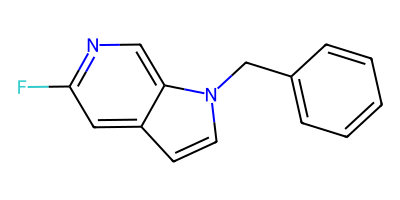

In [26]:
from rdkit import Chem
from rdkit.Chem import Draw

# create a molecule from the MDAnalysis selection
lmol = plf.Molecule.from_mda(lig)
# cleanup before drawing
mol = Chem.RemoveHs(lmol)
mol.RemoveAllConformers()
Draw.MolToImage(mol, size=(400, 200))

In [27]:
# You can modify the residue number to show the pocket in the next 3D image
#viewer.setStyle({'resi': '30'}, {'stick': {'colorscheme': 'blueCarbon'}})
# After having changed the residues, re-run the next two cells

In [28]:
#@title Define display style
#@title Define receptor name
TargetProtein = Protein_PDB_file_name
def DrawDocking(protein,ligand):
     complex_pl = Chem.MolToPDBBlock(protein)
     docked_pdb = Chem.MolToPDBBlock(ligand)
     viewer = py3Dmol.view(width=800,height=800)
     viewer.addModel(complex_pl,'pdb')
     viewer.addModel(docked_pdb)
     prot = {'resn': ["DMS", "UNL", "SO4", "LIG", "HOH", "Cl"], 'invert': 1}  #define prot as all except list
     viewer.setStyle(prot,{'cartoon': {'colorscheme':'ssPyMol'}}) # Colour by secondary structure
     Lig_373 = {'resn' : 'LIG'} #original ligand in pdb file
     MyLig = {'resn':'UNL'} #ligand to be added from docking
     viewer.addSurface(py3Dmol.VDW,{'opacity':0.7, 'color': 'white'}, prot)
     viewer.setStyle({'resi': '30'}, {'stick': {'colorscheme': 'blueCarbon'}})
     viewer.setStyle({'resi': '80'}, {'stick': {'colorscheme': 'blueCarbon'}})
     viewer.setStyle({'resi': '311'}, {'stick': {'colorscheme': 'blueCarbon'}})
     viewer.setStyle(Lig_373,{'stick':{'colorscheme': 'whiteCarbon','radius':.1}}) 
     viewer.setStyle(MyLig,{'stick':{'colorscheme' : 'greenCarbon'}})
     viewer.zoomTo(MyLig)
     return viewer 

# Generate 2D/3D interaction diagram (It's normal if there is an error for the 2D, it is still under optimisation)
- 2D interaction diagram is not stable, for most of the case it would work, for some not
- You can always download the docked file to your local computer for further analysis
- Download combined1.pdb as the docked top1 protein-ligand complex, from the left file list
- Click the top left corner folder to show the files, right click to save docked file to local
- Show up the hidden cells by clcking the play button, a word of warning, it is extremely overwhelming if you not familar with basic shell and python. Click again to collapse cells

In [29]:
#@title Show the docked pocket (zoom in)
receptor = Chem.MolFromPDBFile(TargetProtein)
DrawDocking(receptor,mols[0])

[12:04:17] WARNING: not removing hydrogen atom without neighbors


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [30]:
from prolif.plotting.network import LigNetwork

fp = plf.Fingerprint()
fp.run(u.trajectory[::10], lig, prot)
df = fp.to_dataframe(return_atoms=True)

net = LigNetwork.from_ifp(
    df,
    lmol,
    # replace with `kind="frame", frame=0` for the other depiction
    kind="aggregate",
    threshold=0.3,
    rotation=270,
)
net.display()

  0%|          | 0/1 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:432: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"
/srv/conda/envs/notebook/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:432: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"
/srv/conda/envs/notebook/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:432: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"
/srv/conda/envs/notebook/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:432: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"
/srv/conda/envs/notebook/lib/python3.8/multiprocessing/reduction

# Prepare result and interaction report


In [55]:
!mamba install -c conda-forge plip=2.3.0 -y > install_log.txt 2>&1

In [56]:
!plip -f combined1.pdb -t

2023-10-30 12:42:21,343 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2023-10-30 12:42:21,343 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2023-10-30 12:42:21,343 [INFO] [plipcmd.py:126] plip.plipcmd: please cite: Adasme,M. et al. PLIP 2021: expanding the scope of the protein-ligand interaction profiler to DNA and RNA. Nucl. Acids Res. (05 May 2021), gkab294. doi: 10.1093/nar/gkab294
2023-10-30 12:42:21,343 [INFO] [plipcmd.py:49] plip.plipcmd: starting analysis of combined1.pdb
2023-10-30 12:42:22,137 [INFO] [plipcmd.py:163] plip.plipcmd: finished analysis, find the result files in the working directory


In [57]:
!mkdir result
!cp combined1.pdb result/
!cp D
!cp report.txt result/
!tar -cvf result.zip result/

mkdir: cannot create directory ‘result’: File exists
result/
result/report.txt
result/combined1.pdb


# Click download files to download the best pose and an interaction report


In [59]:
from IPython.display import display, HTML

def create_download_link(filename, text="Download File"):
    html = f'<a href="{filename}" download>{text}</a>'
    return HTML(html)

# Create the download link
download_link = create_download_link("result.zip", "Download My File")

# Display the download link
display(download_link)


# References


- This notebook is written by https://github.com/quantaosun
All the dependencies used are open soured, they are 

*   rdkit
*   openbabel
*   py3Dmol 
*   pymol-open-source 
*   smina.static
*   MDAnalysis
*   ProLif
*   Python 3.8
*   conda
*   colab conda

- This notebook has referred [Is life worth living](https://www.cheminformania.com/ligand-docking-with-smina/)
- Thi notebook has referred [Jupyter Notebook for docking either locally or using Colab](https://www.macinchem.org/reviews/JupyterDocking/jupyterdocking.php)
 